In [1]:
!git clone https://github.com/Daisybiubiubiu/EEG-Emotion-Recognition.git


Cloning into 'EEG-Emotion-Recognition'...
remote: Enumerating objects: 3877, done.
remote: Total 3877 (delta 0), reused 0 (delta 0), pack-reused 3877
Receiving objects: 100% (3877/3877), 308.93 MiB | 24.32 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (2566/2566), done.


In [0]:
#!ls -R

In [0]:
#!cd ./EEG-Emotion-Recognition  

In [0]:
#!ls

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import time

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [6]:
# load data
frameNum = 30
dfs = []
for i in range(1,33):
  for j in range(1,41):
    filename = './EEG-Emotion-Recognition/CWT/File_30frame_exscale/participant%dvideo%d.txt'%(i,j)
    cols = [i for i in range(frameNum)]
    df = pd.read_csv(filename, header = None, usecols = cols, delimiter=',')   
    dfs.append(df.values)
    #print('participant%dvideo%d.txt'%(i,j))

dfs = np.array(dfs)
print('dataLoaded:')
print(dfs.shape)

dataLoaded:
(1280, 1024, 30)


In [0]:
# normalize
x_min = dfs.min(axis = (1,2),keepdims=True)
x_max = dfs.max(axis = (1,2),keepdims=True)
dfs_normal = (dfs-x_min)/(x_max-x_min)


In [8]:
# load label
cols = ['valence', 'arousal', 'dominance', 'liking']
label_df = pd.read_csv('./EEG-Emotion-Recognition/CWT/label.txt',
    usecols = [i for i in range(4)], header=None, delimiter=',' )
print(label_df.shape)
label_df.columns = cols
label_df[label_df<5] = 0
label_df[label_df>=5] = 1


(1280, 4)


In [9]:
# valence
label = label_df['valence'].values
print(label.size)


1280


In [10]:
# divive train & test
x_train, x_test, y_train, y_test = train_test_split(dfs_normal, label, test_size=0.2, random_state=1)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

n = x_train.shape[0]
print(n)

1024


In [0]:
class cnn_classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv11 = nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv12 = nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool3d(kernel_size=2, padding=0)
    
    self.conv21 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv22 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool3d(kernel_size=2, padding=(0,0,1))
    
    self.conv31 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv32 = nn.Conv3d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.pool3 = nn.MaxPool3d(kernel_size=2, padding=0)
    

    self.fc_layer = nn.Linear(128*4*4*4, 2)
    
    self.dropout_layer = nn.Dropout(p=0.5)

  def forward(self, xb):
    h1 = self.conv11(xb)
    h1 = self.conv12(h1)
    h1 = self.dropout_layer(h1)
    h1 = self.pool1(h1)
    h1 = F.relu(h1)

    h2 = self.conv21(h1)
    h2 = self.conv22(h2)
    h2 = self.dropout_layer(h2)
    h2 = self.pool2(h2)
    h2 = F.relu(h2) 

    h3 = self.conv31(h2)
    h3 = self.conv32(h3)
    #]h3 = self.dropout_layer(h3)
    h3 = self.pool3(h3)
    h3 = F.relu(h3) 
    
    # flatten the output from conv layers before feeind it to FC layer
    flatten = h3.view(-1, 128*4*4*4)
    out = self.fc_layer(flatten)    
    return out


In [0]:
def train_model(model, x_train, y_train, x_test, y_test, epochs=50 , batch_size=32, lr=0.0001, weight_decay=0):
  # data
  train_dataset = TensorDataset(x_train, y_train)
  train_data_loader = DataLoader(train_dataset, batch_size=batch_size)

  # loss function
  loss_func = F.cross_entropy

  # optimizer
  #optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

  # figure
  train_a = list([])
  test_a = list([])

  # training loop
  for epoch in range(epochs):
    model.train()
    tic = time.time()
    acc_train = []
    for xb, yb in train_data_loader:    
      xb, yb = xb.to(device), yb.to(device)
      pred = model(xb)
      loss = loss_func(pred, yb)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      acc_train.append(pred.detach().argmax(1).eq(yb).float().mean().cpu().numpy())
    acc_train = np.mean(acc_train)
    toc = time.time()
    
    with torch.no_grad():
      model.eval()
      y_pred = model(x_test.to(device))
      acc = y_pred.argmax(1).eq(y_test.to(device)).float().mean().cpu().numpy()

    train_a.append(acc_train)
    test_a.append(acc)
    print('Loss at epoch %d : %f, train_acc: %f, test_acc: %f, running time: %d'% (epoch, loss.item(), acc_train, acc, toc-tic))

  # draw an accuray figure
  plt.plot(train_a,'y.-.')
  plt.plot(test_a,'.-.')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')


Loss at epoch 0 : 0.714294, train_acc: 0.570312, test_acc: 0.546875, running time: 6
Loss at epoch 1 : 0.711559, train_acc: 0.570312, test_acc: 0.546875, running time: 6
Loss at epoch 2 : 0.708031, train_acc: 0.570312, test_acc: 0.546875, running time: 6
Loss at epoch 3 : 0.706613, train_acc: 0.564453, test_acc: 0.546875, running time: 6
Loss at epoch 4 : 0.699232, train_acc: 0.570312, test_acc: 0.546875, running time: 6
Loss at epoch 5 : 0.700139, train_acc: 0.571289, test_acc: 0.546875, running time: 6
Loss at epoch 6 : 0.688026, train_acc: 0.575195, test_acc: 0.546875, running time: 6
Loss at epoch 7 : 0.691549, train_acc: 0.580078, test_acc: 0.554688, running time: 6
Loss at epoch 8 : 0.657757, train_acc: 0.609375, test_acc: 0.574219, running time: 6
Loss at epoch 9 : 0.637598, train_acc: 0.634766, test_acc: 0.582031, running time: 6
Loss at epoch 10 : 0.644754, train_acc: 0.659180, test_acc: 0.566406, running time: 6
Loss at epoch 11 : 0.589231, train_acc: 0.681641, test_acc: 0.61

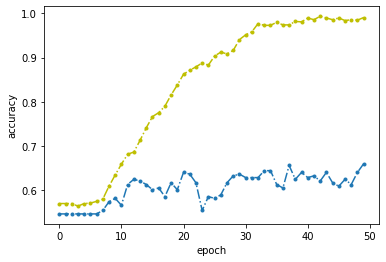

In [13]:
model = cnn_classifier()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
train_model(model, x_train.view(-1, 1, 32, 32, frameNum), y_train, x_test.view(-1, 1, 32, 32, frameNum), y_test)